# Exploratory Data Analysis (EDA) - Lung Cancer CT Scan Dataset

This notebook explores the chest CT scan dataset used for training a deep learning model
to classify between:
- Normal (No Cancer)
- Adenocarcinoma
- Large-Cell Carcinoma
- Squamous Cell Carcinoma

The goal is to understand the dataset, check class distributions, and visualize sample images
before training.

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from collections import Counter

DATA_DIR = "../dataset"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "valid"),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)

2025-08-19 13:00:12.896962: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.
Classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']


## Class Distribution

We check how balanced the dataset is across the four classes.
Imbalanced datasets can affect training and may require techniques like class weighting or data augmentation.

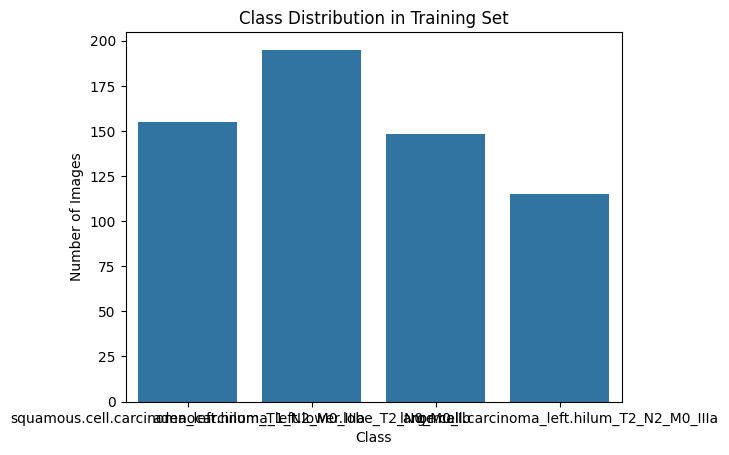

In [2]:
# Count labels in train dataset
label_counts = Counter()
for _, labels in train_ds.unbatch():
    label_counts[int(labels.numpy())] += 1

# Plot distribution
sns.barplot(x=[class_names[k] for k in label_counts.keys()], y=label_counts.values())
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.show()

## Sample Images per Class

Let’s visualize some sample CT scan images from each class to get a sense of what the data looks like.

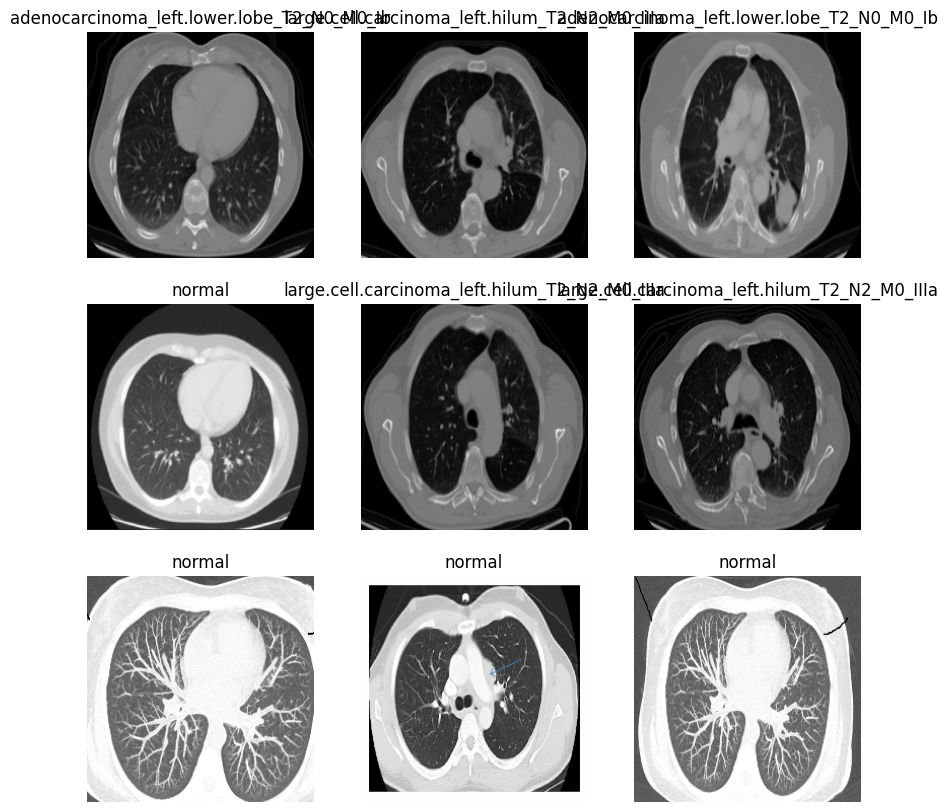

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Image Shapes

We check the shape of the images and confirm the preprocessing step (resizing).


In [4]:
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


## Pixel Value Range

Since deep learning models perform better when inputs are normalized,
we confirm the pixel value scaling.

In [5]:
for images, labels in train_ds.take(1):
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())

Min pixel value: 0.0
Max pixel value: 255.0


## Data Augmentation 

If we plan to use augmentation, let’s preview some transformations.


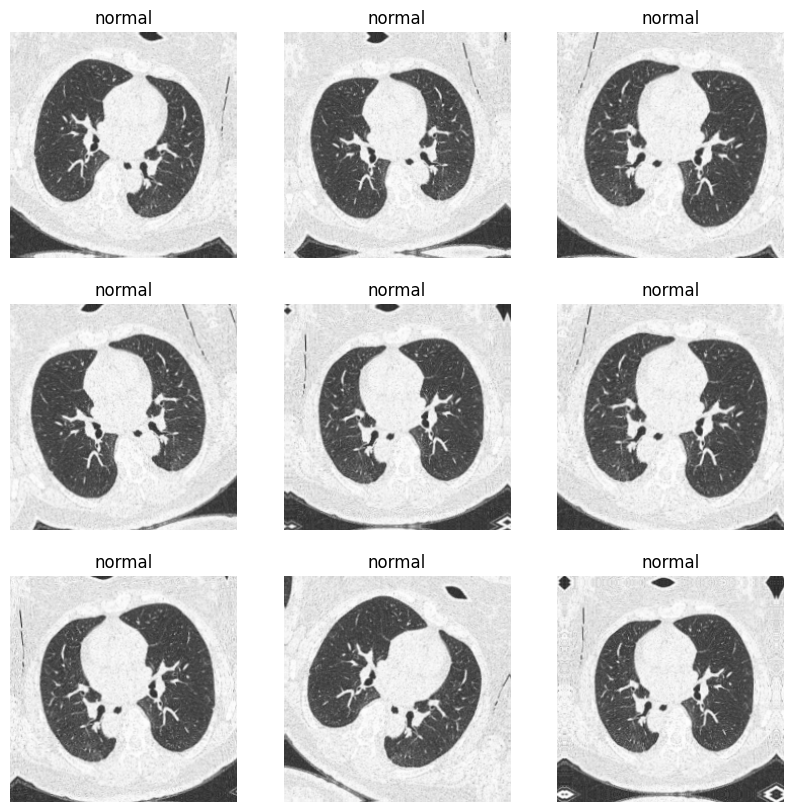

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Show augmented images
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")
    break